<a href="https://colab.research.google.com/github/vishnuvryeruva/Approximate-Nearest-Neighbor/blob/main/Approximate_Nearest_Neighbor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

In [2]:
! pip install nmslib

     |████████████████████████████████| 13.5 MB 4.5 MB/s 
     |████████████████████████████████| 188 kB 69.1 MB/s 


In [3]:
! pip install faiss

     |████████████████████████████████| 4.7 MB 5.4 MB/s 


In [4]:
!apt-get install libomp-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 239 kB of archives.
After this operation, 804 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp5 amd64 5.0.1-1 [234 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp-dev amd64 5.0.1-1 [5,088 B]
Fetched 239 kB in 1s (361 kB/s)
Selecting previously unselected package libomp5:amd64.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../libomp5_5.0.1-1_amd64.deb ...
Unpacking libomp5:amd64 (5.0.1-1) ...
Selecting previously unselected package libomp-dev.
Preparing to unpack .../libomp-dev_5.0.1-1_amd64.deb ...
Unpacking libomp-dev (5.0.1-

In [5]:
! pip install annoy

     |████████████████████████████████| 646 kB 5.1 MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391689 sha256=99948243db5385efecc6e85d9ab203f4576a5736e236083a72a49cc5344f03c7
  Stored in directory: /root/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy


In [6]:
digits = load_digits(n_class=5)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
X.shape

(901, 64)

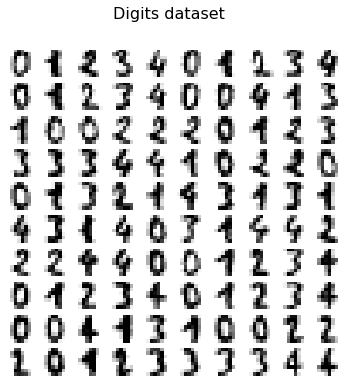

In [7]:
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("Digits dataset", fontsize=16)

In [8]:
from sklearn.manifold import TSNE

tsne_2 = TSNE()
data_embeddings_tsne_2 = tsne_2.fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [9]:
data_embeddings_tsne_2.shape

(901, 2)

In [10]:
import nmslib

In [11]:
hnsw_index = nmslib.init(method='hnsw', space='cosinesimil')
hnsw_index.addDataPointBatch(data_embeddings_tsne_2)
hnsw_index.createIndex({'post': 2})

In [12]:
y[80]

0

In [13]:
hnsw_output = hnsw_index.knnQuery(data_embeddings_tsne_2[80], k=10)
hnsw_output_list = [y[i] for i in hnsw_output[0]]
hnsw_output_list

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [14]:
import faiss

In [15]:
exhaustive_search = faiss.IndexFlatL2(data_embeddings_tsne_2.shape[1])
exhaustive_search.add(data_embeddings_tsne_2)

In [16]:
distances, indices = exhaustive_search.search(data_embeddings_tsne_2[80:81], 10) 
exhaustive_search_output_list = [y[i] for i in indices[0]]

In [17]:
exhaustive_search_output_list

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [18]:
number_of_partition = 8
search_in_x_partitions = 2
subvector_size = 8

pq_quantizer = faiss.IndexFlatL2(data_embeddings_tsne_2.shape[1])
pq = faiss.IndexIVFPQ(pq_quantizer, data_embeddings_tsne_2.shape[1], number_of_partition, search_in_x_partitions, subvector_size)
pq.train(data_embeddings_tsne_2)
pq.add(data_embeddings_tsne_2)

In [19]:
distances, indices = pq.search(data_embeddings_tsne_2[90:91], 10) 
pq_output_list =  [y[i] for i in indices[0]]
pq_output_list

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [20]:
lsh = faiss.IndexLSH(data_embeddings_tsne_2.shape[1], 4)
lsh.add(data_embeddings_tsne_2)

In [21]:
distances, indices = lsh.search(data_embeddings_tsne_2[80:81], k=10)
lsh_output_list =  [y[i] for i in indices[0]]
lsh_output_list

[0, 0, 0, 2, 0, 0, 0, 0, 0, 0]

In [22]:
import annoy

In [23]:
number_of_trees = 5
annoy_index = annoy.AnnoyIndex(data_embeddings_tsne_2.shape[1])
for i, vec in enumerate(data_embeddings_tsne_2):
  annoy_index.add_item(i, vec.tolist())
annoy_index.build(number_of_trees)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  


True

In [24]:
annoy_indices = annoy_index.get_nns_by_vector(data_embeddings_tsne_2[90].tolist(), 10)
annoy_output_list = [y[i] for i in annoy_indices]

In [25]:
annoy_output_list

[2, 2, 0, 0, 0, 0, 0, 0, 0, 0]

In [26]:
graph_index = faiss.IndexHNSWFlat(data_embeddings_tsne_2.shape[1], 10)
graph_index.add(data_embeddings_tsne_2)

distances, indices = graph_index.search(data_embeddings_tsne_2[90:91], k=10)
graph_output_list = [y[i] for i in indices[0]]
graph_output_list

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

**REFERENCES**

https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/semantic_approximate_nearest_neighbors.ipynb

https://www.youtube.com/watch?v=OO7Y5wQWnQs&ab_channel=ProgrammingKnowledge

https://github.com/spotify/annoy

https://www.youtube.com/watch?v=7_CIQf73Oj0&ab_channel=wiqaaas